### 目的
過去のデータから心疾患がある(condition = 1)患者を予測するモデルを構築

### ライブラリ・データ読み込み

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('パスを指定')
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


### 欠損値・重複値確認

In [36]:
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [37]:
df.duplicated().sum()

np.int64(0)

### 基本統計量・俯瞰

In [4]:
df.shape

(297, 14)

In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


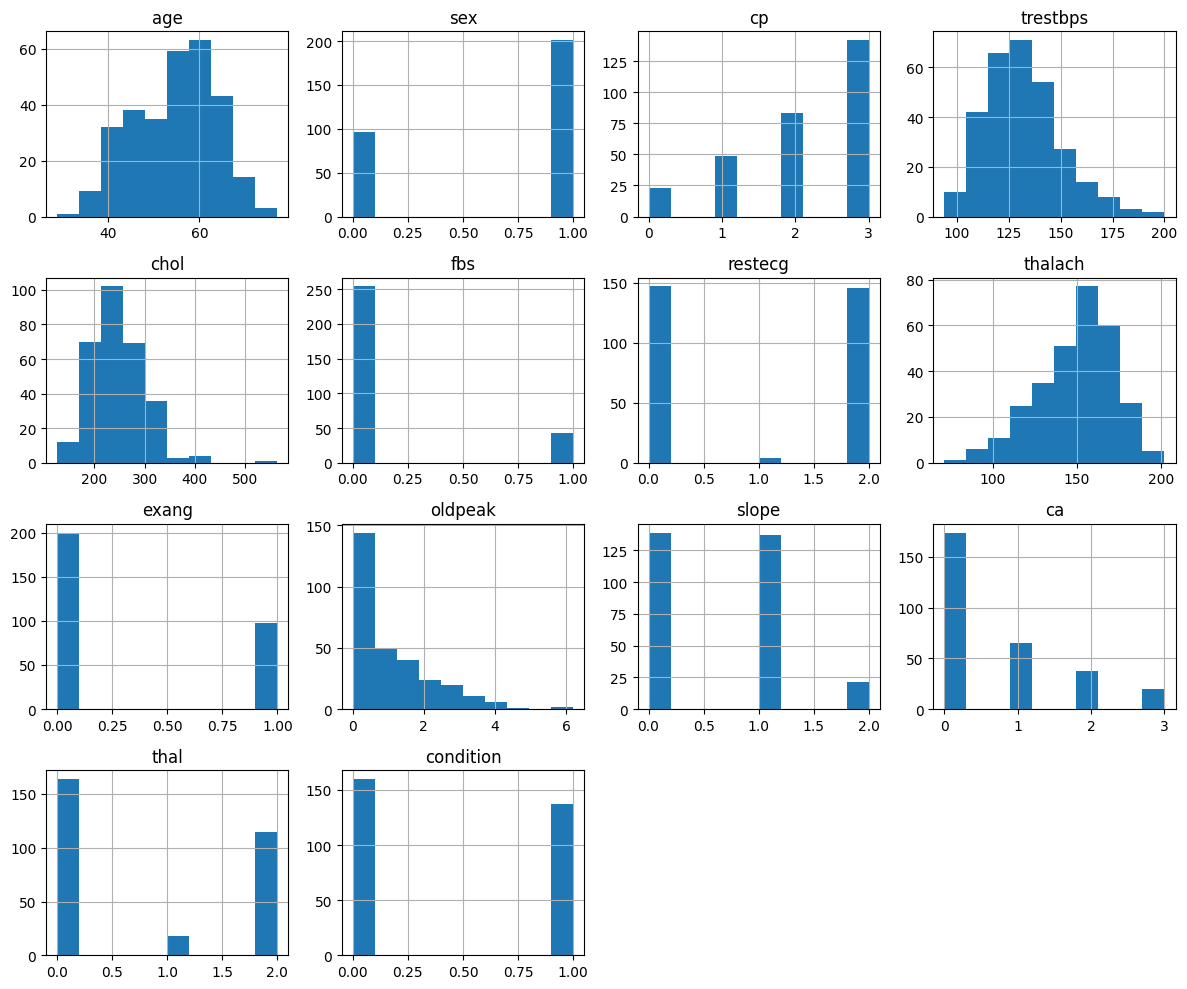

In [6]:
df.hist(figsize = (12, 10))
plt.tight_layout()

plt.show()

### 仮説
- 性別(sex)によって、心疾患を患う確率が異なるのではないか
- 年齢(age)は、心疾患を患う確率に影響を与えるのではないか
- 安静時血圧(trestbps)の値は、心疾患を患う確率に影響を与えるのではないか
- 血清コレステロール値(chol)の値は、心疾患を患う確率に影響を与えるのではないか

### 仮説検証

In [46]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
age,1.000000,-0.092399,0.110471,0.290476,0.202644,0.132062,0.149917,-0.394563,0.096489,0.197123,0.159405,0.362210,0.120795,0.227075
sex,-0.092399,1.000000,0.008908,-0.066340,-0.198089,0.038850,0.033897,-0.060496,0.143581,0.106567,0.033345,0.091925,0.370556,0.278467
cp,0.110471,0.008908,1.000000,-0.036980,0.072088,-0.057663,0.063905,-0.339308,0.377525,0.203244,0.151079,0.235644,0.266275,0.408945
trestbps,0.290476,-0.066340,-0.036980,1.000000,0.131536,0.180860,0.149242,-0.049108,0.066691,0.191243,0.121172,0.097954,0.130612,0.153490
chol,0.202644,-0.198089,0.072088,0.131536,1.000000,0.012708,0.165046,-0.000075,0.059339,0.038596,-0.009215,0.115945,0.023441,0.080285
fbs,0.132062,0.038850,-0.057663,0.180860,0.012708,1.000000,0.068831,-0.007842,-0.000893,0.008311,0.047819,0.152086,0.051038,0.003167
restecg,0.149917,0.033897,0.063905,0.149242,0.165046,0.068831,1.000000,-0.072290,0.081874,0.113726,0.135141,0.129021,0.013612,0.166343
thalach,-0.394563,-0.060496,-0.339308,-0.049108,-0.000075,-0.007842,-0.072290,1.000000,-0.384368,-0.347640,-0.389307,-0.268727,-0.258386,-0.423817
exang,0.096489,0.143581,0.377525,0.066691,0.059339,-0.000893,0.081874,-0.384368,1.000000,0.289310,0.250572,0.148232,0.323268,0.421355
oldpeak,0.197123,0.106567,0.203244,0.191243,0.038596,0.008311,0.113726,-0.347640,0.289310,1.000000,0.579037,0.294452,0.336809,0.424052


結果解釈
- 性別(sex)によって、心疾患を患う確率が異なるのではないか <br>
　→性別と心疾患の有無には相関が見られないが、説明変数として使用する
- 年齢(age)は、心疾患を患う確率に影響を与えるのではないか <br>
　→年齢と心疾患の有無に大きな相関は見られないが、説明変数として使用する
- 安静時血圧(trestbps)の値は、心疾患を患う確率に影響を与えるのではないか <br>
　→安静時血圧と心疾患の有無に大きな相関は見られないが、説明変数として使用する
- 血清コレステロール値(chol)の値は、心疾患を患う確率に影響を与えるのではないか <br>
　→血清コレステロール値と心疾患の有無に大きな相関は見られないため、説明変数として使用しない

### ロジスティック回帰分析

#### モデル学習

In [30]:
X = df[['sex', 'age', 'trestbps']]
y = df['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3, stratify = df['sex'])

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (207, 3)
X_test: (90, 3)
y_train: (207,)
y_test: (90,)


In [31]:
model = LR()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#### 精度評価

In [34]:
cm = cm(y_test, y_pred)
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["actual_Positive", "actual_Negative"], columns=["predict_Positive", "predict_Negative"])
f_one = f1_score(y_test, y_pred)

print(df_cm, '\n')
print(f'f1_score：{f_one}')

                 predict_Positive  predict_Negative
actual_Positive                25                14
actual_Negative                17                34 

f1_score：0.6172839506172839


#### モデル改善

相関係数からcp, exang, oldpeak, ca, thalを説明変数として追加する

In [36]:
X = df[['sex', 'age', 'trestbps', 'cp', 'exang', 'oldpeak', 'ca', 'thal']]
y = df['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, stratify = y, test_size = 0.3)

smote = SMOTE(random_state = 0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f'X_train_resampled: {X_train_resampled.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train_resampled: {y_train_resampled.shape}')
print(f'y_test: {y_test.shape}')

X_train_resampled: (224, 8)
X_test: (90, 8)
y_train_resampled: (224,)
y_test: (90,)


In [37]:
model_2 = LR()
model_2.fit(X_train_resampled, y_train_resampled)

y_pred_2 = model_2.predict(X_test)

In [46]:
cm = cm(y_test, y_pred)
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["actual_Positive", "actual_Negative"], columns=["predict_Positive", "predict_Negative"])
f_one_2 = f1_score(y_test, y_pred_2)

print(df_cm, '\n')
print(f'f1_score_2：{f_one_2}')

                 predict_Positive  predict_Negative
actual_Positive                27                15
actual_Negative                15                33 

f1_score_2：0.8536585365853658
